In [2]:
import json
import os

os.environ["OPENBLAS_NUM_THREADS"] = "32"

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist

%matplotlib inline

import numpy as np
from tqdm.auto import tqdm

from how_to_sample.simulations import (
    cluster_identification_accuracy,
    generate_gaussian_mixture_samples,
    participation_ratio,
    ridge_regression_closed_form,
)

np.random.seed(42)  # for reproducibility


# Function to generate samples around a center
def generate_cluster_samples(center, n_samples, noise_std=1.0, seed=None, D=2):
    rng = np.random.RandomState(seed)
    noise = rng.normal(0, noise_std, size=(n_samples, D))
    return center + noise


def get_RDM(Y):
    """Calculate the Representational Dissimilarity Matrix (RDM) efficiently.

    Args:
        Y: Input array of shape (n_samples, n_features)

    Returns:
        rdm: Array of shape (n_samples, n_samples) containing pairwise distances
    """
    # Calculate squared Euclidean distances efficiently using broadcasting
    sq_dists = np.sum((Y[:, np.newaxis, :] - Y[np.newaxis, :, :]) ** 2, axis=2)

    # Take square root to get Euclidean distances
    rdm = np.sqrt(sq_dists)

    return rdm


plot_out_dir = Path(
    "/home/jroth/controversial_stimuli/experiments/laion/edopt_testing/notebooks/plots/3_simulate_stimvsfMRI_ed"
)

2025-04-18 08:06:29.881006: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 08:06:31.438517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744956392.133156 2226466 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744956392.303773 2226466 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 08:06:33.617556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Simulate how ED affects output dimension collaps

## Replicate figure 9B as sanity check + How does the number of clusters affect the effective dimensionality of the training set?

In [33]:
N = 50000
D = 512

sigma2_intra = 10.0 / D
sigma2_inter = 100.0 / D
sigma2_noise = 0.25
lam = 1.0

iid_accuracies = []
ood_accuracies = []
ed_tr_values = []

C_values = [int(C) for C in np.logspace(0, 3, 10)]

for C in tqdm(C_values):
    teacher_weights = np.random.normal(loc=0.0, scale=(1.0 / np.sqrt(D)), size=(D, D))

    # Generate big training set
    X_tr, Ytr, mu_tr = generate_gaussian_mixture_samples(
        N=N,
        C=C,
        D=D,
        sigma2_intra=sigma2_intra,
        sigma2_inter=sigma2_inter,
        teacher_weights=teacher_weights,
        sigma2_noise=sigma2_noise,
        random_state=42,
    )

    ed_tr = participation_ratio(np.linalg.eigvalsh(np.cov(X_tr, rowvar=False)))
    ed_tr_values.append(ed_tr)

    # Train the student
    W = ridge_regression_closed_form(X_tr, Ytr, lam=lam)

    # Now, evaluate zero-shot performance with cluster identification
    # We do T=32 repeated trials, each with N_test=100, etc.
    t = min(C, 32)
    in_dist_accuracy = cluster_identification_accuracy(
        W=W,
        teacher_weights=teacher_weights,
        cluster_centers=mu_tr,
        sigma2_intra=sigma2_intra,
        sigma2_noise=sigma2_noise,
        n=100,
        t=32,
        ood=False,
    )

    out_of_dist_accuracy = cluster_identification_accuracy(
        W=W,
        teacher_weights=teacher_weights,
        cluster_centers=mu_tr,
        sigma2_intra=sigma2_intra,
        sigma2_noise=sigma2_noise,
        n=100,
        t=32,
        ood=True,
        sigma2_inter=sigma2_inter,
    )

    iid_accuracies.append(in_dist_accuracy)
    ood_accuracies.append(out_of_dist_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

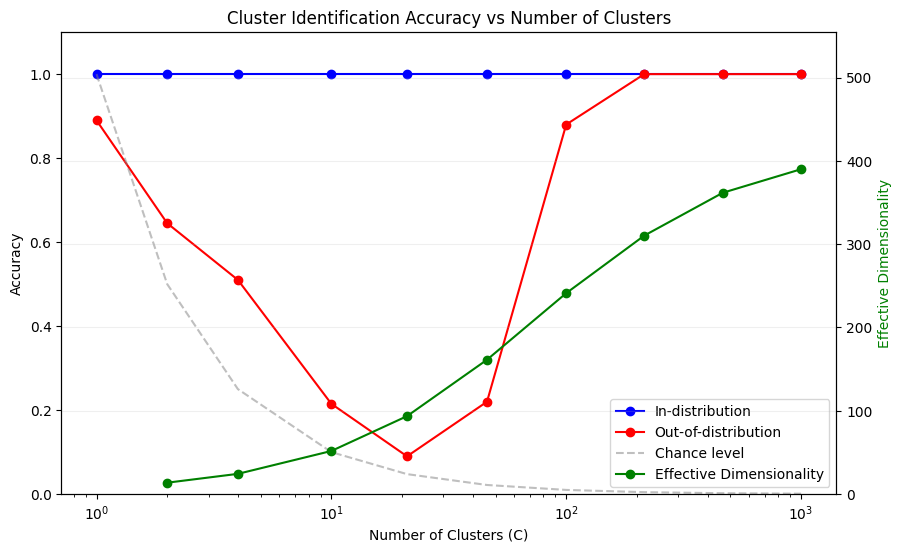

In [36]:
chance_levels = 1.0 / np.array(C_values)

plt.figure(figsize=(10, 6))

# Create first y-axis and plot accuracies
ax1 = plt.gca()
ax1.semilogx(C_values, iid_accuracies, "o-", label="In-distribution", color="blue")
ax1.semilogx(C_values, ood_accuracies, "o-", label="Out-of-distribution", color="red")
ax1.semilogx(
    C_values, chance_levels, "--", label="Chance level", color="gray", alpha=0.5
)

# Create second y-axis and plot ED
ax2 = ax1.twinx()
ax2.semilogx(
    C_values[1:],
    ed_tr_values[1:],
    "o-",
    label="Effective Dimensionality",
    color="green",
)

# Set labels for both axes
ax1.set_xlabel("Number of Clusters (C)")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Effective Dimensionality", color="green")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

# Customize the plot
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.title("Cluster Identification Accuracy vs Number of Clusters")

# Set y-axis limits
ax1.set_ylim(0, 1.1)
ax2.set_ylim(0, max(ed_tr_values) * 1.1)  # Scale ED axis to data

plt.show()

## Low dimensional case

## First: how does the total number of samples affect OOD accuracy (if we have enough clusters in principle)?

In [7]:
D = 512

sigma2_intra = 10.0 / D
sigma2_inter = 100.0 / D
sigma2_noise = 0.25
lam = 1.0

In [8]:
def eval_dataset(X_tr, Y_tr, mu_tr, sigma2_intra, sigma2_inter, sigma2_noise, lam):
    W = ridge_regression_closed_form(X_tr, Y_tr, lam=lam)

    in_dist_accuracy = cluster_identification_accuracy(
        W=W,
        teacher_weights=teacher_weights,
        cluster_centers=mu_tr,
        sigma2_intra=sigma2_intra,
        sigma2_noise=sigma2_noise,
        n=100,
        t=32,
        ood=False,
    )

    out_of_dist_accuracy = cluster_identification_accuracy(
        W=W,
        teacher_weights=teacher_weights,
        cluster_centers=mu_tr,
        sigma2_intra=sigma2_intra,
        sigma2_noise=sigma2_noise,
        n=100,
        t=32,
        ood=True,
        sigma2_inter=sigma2_inter,
    )

    return W, in_dist_accuracy, out_of_dist_accuracy

In [9]:
from how_to_sample.simulations import (
    correlation,
    ridge_regression_closed_form,
)

D = 512
num_in_clusters = 100

teacher_weights = np.random.normal(loc=0.0, scale=(1.0 / np.sqrt(D)), size=(D, D))

iid_accuracies = []
ood_accuracies = []
ed_tr_values = []

N_values = [int(N) for N in np.logspace(2, 5, 10)]

for N in tqdm(N_values):
    X_tr, Y_tr, mu_tr = generate_gaussian_mixture_samples(
        N=N,
        C=num_in_clusters,
        D=D,
        sigma2_intra=sigma2_intra,
        sigma2_inter=sigma2_inter,
        teacher_weights=teacher_weights,
        sigma2_noise=sigma2_noise,
        random_state=42,
    )

    ed_tr = participation_ratio(np.linalg.eigvalsh(np.cov(X_tr, rowvar=False)))
    ed_tr_values.append(ed_tr)

    W, in_dist_accuracy, out_of_dist_accuracy = eval_dataset(
        X_tr, Y_tr, mu_tr, sigma2_intra, sigma2_inter, sigma2_noise, lam
    )

    iid_accuracies.append(in_dist_accuracy)
    ood_accuracies.append(out_of_dist_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

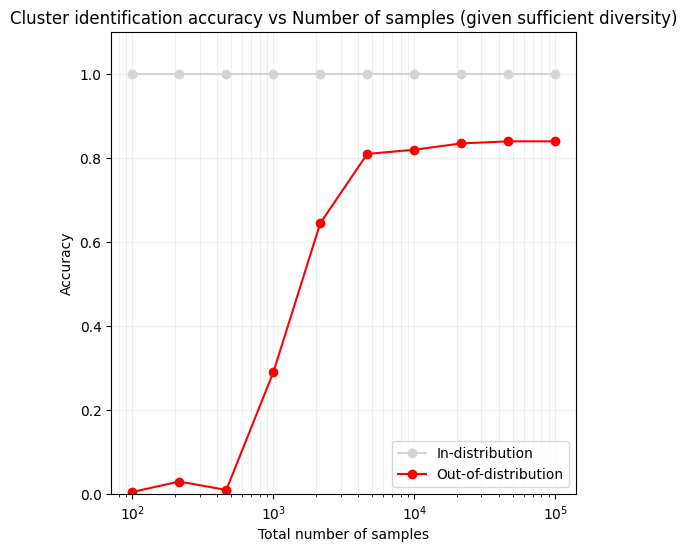

In [46]:
plt.figure(figsize=(6, 6))
# Create first y-axis and plot accuracies
ax1 = plt.gca()
ax1.semilogx(N_values, iid_accuracies, "o-", label="In-distribution", color="lightgray")
ax1.semilogx(N_values, ood_accuracies, "o-", label="Out-of-distribution", color="red")

# Set labels for both axes
ax1.set_xlabel("Total number of samples")
ax1.set_ylabel("Accuracy")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc="lower right")

# Customize the plot
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.title(
    "Cluster identification accuracy vs Number of samples (given sufficient diversity)"
)

# Set y-axis limits
ax1.set_ylim(0, 1.1)

plt.savefig(plot_out_dir / "cluster_identification_accuracy_vs_num_samples.pdf")

plt.show()

## With a sample size typical for fMRI studies (6k images per person), generalization can be achieved with relatively high accuracy. How should we select samples then?

In [47]:
from how_to_sample.coverage import test_autoencoder_coverage

In [48]:
D = 512

sigma2_noise = 0.25
sigma2_intra = 10.0 / D
sigma2_inter = 100.0 / D
lam = 1.0

num_in_clusters = 100
N_samples_total = int(1e5)
N_samples_select = 6000

teacher_weights = np.random.normal(loc=0.0, scale=(1.0 / np.sqrt(D)), size=(D, D))

In [49]:
# Generate exactly N_samples_select so that they broadly cover each cluster
X_tr, Y_tr, mu_tr = generate_gaussian_mixture_samples(
    N=N_samples_select,
    C=num_in_clusters,
    D=D,
    sigma2_intra=sigma2_intra,
    sigma2_inter=sigma2_inter,
    teacher_weights=teacher_weights,
    sigma2_noise=sigma2_noise,
    random_state=42,
)

W, in_dist_accuracy, ood_dist_accuracy = eval_dataset(
    X_tr, Y_tr, mu_tr, sigma2_intra, sigma2_inter, sigma2_noise, lam
)
print(
    f"Generated {N_samples_select} samples, in-dist accuracy: {in_dist_accuracy:.2f}, OOD accuracy: {ood_dist_accuracy:.2f}"
)

Generated 6000 samples, in-dist accuracy: 1.00, OOD accuracy: 0.82


In [52]:
# Generate more samples to select from
X_tr, Y_tr, mu_tr = generate_gaussian_mixture_samples(
    N=N_samples_total,
    C=num_in_clusters,
    D=D,
    sigma2_intra=sigma2_intra,
    sigma2_inter=sigma2_inter,
    teacher_weights=teacher_weights,
    sigma2_noise=sigma2_noise,
    random_state=42,
)

In [53]:
N_samples_per_cluster = N_samples_total // num_in_clusters
cluster_indices = [
    list(range(i * N_samples_per_cluster, (i + 1) * N_samples_per_cluster))
    for i in range(num_in_clusters)
]

In [56]:
# Select N_samples_select from X% of the clusters
perc_iid_dists = []
perc_ood_dists = []
eds = []
coverages = []
for percentage in range(20, 100, 20):
    random_cluster_indices_to_select = np.random.choice(
        num_in_clusters, int(num_in_clusters * percentage / 100), replace=False
    )
    selected_indices = []
    for i in random_cluster_indices_to_select:
        selected_indices.extend(
            np.random.choice(
                cluster_indices[i],
                N_samples_select // len(random_cluster_indices_to_select),
                replace=False,
            )
        )

    X_tr_subset, Y_tr_subset = X_tr[selected_indices], Y_tr[selected_indices]
    W, in_dist_accuracy, out_of_dist_accuracy = eval_dataset(
        X_tr_subset, Y_tr_subset, mu_tr, sigma2_intra, sigma2_inter, sigma2_noise, lam
    )
    ed = participation_ratio(np.linalg.eigvalsh(np.cov(X_tr_subset, rowvar=False)))
    coverage, _ = test_autoencoder_coverage(X_tr_subset, X_tr)

    perc_iid_dists.append(in_dist_accuracy)
    perc_ood_dists.append(out_of_dist_accuracy)
    coverages.append(coverage)

    print(
        f"Selected {N_samples_select} samples from {percentage}% of the clusters, ID accuracy: {in_dist_accuracy:.3f}, OOD accuracy: {out_of_dist_accuracy:.3f}, ED: {ed:.3f}, Coverage: {coverage:.3f}"
    )

Selected 6000 samples from 20% of the clusters, ID accuracy: 0.130, OOD accuracy: 0.085, ED: 88.354, Coverage: 11.787
Selected 6000 samples from 40% of the clusters, ID accuracy: 0.435, OOD accuracy: 0.160, ED: 145.496, Coverage: 19.140
Selected 6000 samples from 60% of the clusters, ID accuracy: 1.000, OOD accuracy: 0.390, ED: 184.846, Coverage: 26.442
Selected 6000 samples from 80% of the clusters, ID accuracy: 1.000, OOD accuracy: 0.630, ED: 212.729, Coverage: 36.491


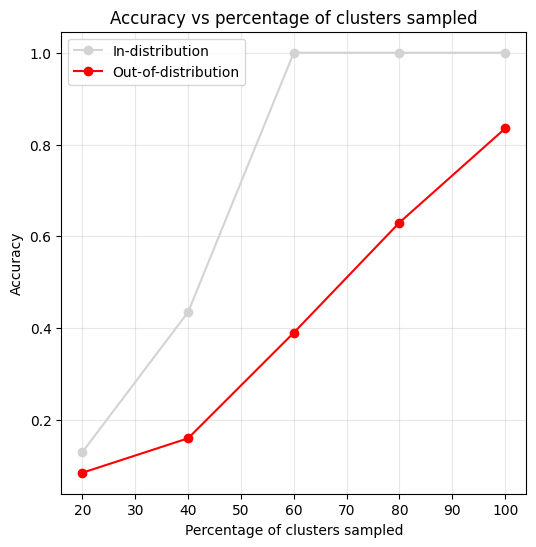

In [ ]:
# Create figure with subplot

# Plot 1: Accuracies vs Percentage of Clusters
percentages = np.arange(20, 120, 20)
plt.figure(figsize=(6, 6))
plt.plot(
    percentages,
    np.concatenate([perc_iid_dists, [in_dist_accuracy_full]]),
    "o-",
    label="In-distribution",
    color="lightgray",
)
plt.plot(
    percentages,
    np.concatenate([perc_ood_dists, [out_of_dist_accuracy_full]]),
    "o-",
    label="Out-of-distribution",
    color="red",
)

plt.xlabel("Percentage of clusters sampled")
plt.ylabel("Accuracy")
plt.title("Accuracy vs percentage of clusters sampled")
plt.grid(True, alpha=0.3)
plt.savefig(plot_out_dir / "accuracy_vs_percentage_of_clusters_sampled.pdf")
plt.legend()

# How much of LAION can be predicted?

In [3]:
from scipy.spatial.distance import squareform
from sklearn.linear_model import RidgeCV

from how_to_sample.data import load_pickle_file

In [4]:
laion_features_path = "/home/jroth/laion_features.npy"
laion_features = np.load(laion_features_path)

In [5]:
optimal_k = 1000
laion_features_dir = Path(laion_features_path).parent
clustering_cache_path = laion_features_dir / f"laion_clustering_k{optimal_k}.pkl"

if clustering_cache_path.exists():
    print(f"Loading cached clustering results from {clustering_cache_path}")
    clustering_data = load_pickle_file(clustering_cache_path)

    final_kmeans = clustering_data["kmeans"]
    final_scaler = clustering_data["scaler"]
    laion_labels = clustering_data["labels"]
# else:
#     print("Clustering LAION features with MiniBatchKMeans...")
#     kmeans, scaler = cluster_full_dataset(laion_features, optimal_k)
#     laion_labels = assign_to_clusters(laion_features, kmeans, scaler)

#     # Cache the results
#     print(f"Saving clustering results to {clustering_cache_path}")
#     clustering_data = {"kmeans": kmeans, "scaler": scaler, "labels": laion_labels}
#     with open(clustering_cache_path, "wb") as f:
#         pickle.dump(clustering_data, f)

Loading cached clustering results from /home/jroth/laion_clustering_k1000.pkl


In [8]:
# N_SAMPLE = 100000
# sample_indices = np.random.choice(len(laion_features), N_SAMPLE, replace=False)
# sample_features = laion_features[sample_indices]

# # Normalize features
# scaler = StandardScaler()
# sample_features_scaled = scaler.fit_transform(sample_features)

In [9]:
# def try_different_clusters(features, k_range=range(5, 51, 5)):
#     results = []

#     for k in tqdm(k_range):
#         # Use MiniBatchKMeans for efficiency
#         kmeans = MiniBatchKMeans(
#             n_clusters=k, batch_size=1000, random_state=42, n_init="auto"
#         )
#         labels = kmeans.fit_predict(features)

#         # Calculate silhouette score on a subset
#         subset_size = min(10000, len(features))
#         subset_idx = np.random.choice(len(features), subset_size, replace=False)
#         sil_score = silhouette_score(
#             features[subset_idx], labels[subset_idx], sample_size=subset_size
#         )

#         inertia = kmeans.inertia_
#         results.append(
#             {"k": k, "silhouette": sil_score, "inertia": inertia, "model": kmeans}
#         )
#         print(f"Completed k={k}, silhouette={sil_score:.3f}")

#     return results

In [10]:
# results = try_different_clusters(sample_features_scaled, k_range=[10, 25, 50, 75, 100, 150, 200, 250])

In [11]:
# # After finding good parameters from sample, apply to full dataset
# def cluster_full_dataset(features, n_clusters, batch_size=10000):
#     # Scale features
#     scaler = StandardScaler()

#     # Fit scaler on a sample if memory is a concern
#     sample_idx = np.random.choice(len(features), 100000, replace=False)
#     scaler.fit(features[sample_idx])

#     # Initialize MiniBatchKMeans
#     kmeans = MiniBatchKMeans(
#         n_clusters=n_clusters, batch_size=batch_size, random_state=42, n_init="auto"
#     )

#     # Process in batches
#     for i in range(0, len(features), batch_size):
#         batch = features[i : i + batch_size]
#         batch_scaled = scaler.transform(batch)
#         if i == 0:
#             kmeans.partial_fit(batch_scaled)
#         else:
#             kmeans.partial_fit(batch_scaled)

#         if i % 1000000 == 0:
#             print(f"Processed {i} samples")

#     return kmeans, scaler

In [12]:
# optimal_k = 1000
# final_kmeans, final_scaler = cluster_full_dataset(laion_features, optimal_k)

In [6]:
def assign_to_clusters(new_features, kmeans_model, scaler, batch_size=10000):
    labels = []
    for i in tqdm(range(0, len(new_features), batch_size)):
        batch = new_features[i : i + batch_size]
        scaled_features = scaler.transform(batch)
        labels.append(kmeans_model.predict(scaled_features))

    labels = np.concatenate(labels)

    return labels

## How well can we predict an OOD cluster with all other clusters or only subsets of all other clusters?

First simulate fMRI data for all LAION samples to predict.

In [7]:
D = laion_features.shape[1]
sigma2_noise = 0.25
teacher_weights = np.random.normal(loc=0.0, scale=(1.0 / np.sqrt(D)), size=(D, D))

In [15]:
# laion_labels = assign_to_clusters(laion_features, final_kmeans, final_scaler)

In [8]:
# Draw a subset (500 samples per cluster)
unique_labels, cts = np.unique(laion_labels, return_counts=True)
laion_subset = []
laion_subset_labels = []
for i in range(1000):
    laion_subset.append(
        laion_features[np.random.choice(np.where(laion_labels == i)[0], 500)]
    )
    laion_subset_labels.append(i * np.ones(500))
laion_subset = np.concatenate(laion_subset)
laion_subset_labels = np.concatenate(laion_subset_labels)

In [9]:
unique_laion_labels, laion_cts = np.unique(laion_labels, return_counts=True)

In [26]:
# # average distance between cluster centers
# pairwise_distances = pdist(final_kmeans.cluster_centers_, metric="euclidean")
# mean_inter_distance = np.mean(pairwise_distances)
# std_inter_distance = np.std(pairwise_distances)

# print(f"Mean Inter-Cluster Distance: {mean_inter_distance:.3f}")
# print(f"Std Dev of Inter-Cluster Distances: {std_inter_distance:.3f}")

In [27]:
# # average distance of samples within clusters (subsampled)
# intra_distances = []
# for i in tqdm(range(1000)):
#     pairwise_distances = pdist(
#         laion_subset[laion_subset_labels == i], metric="euclidean"
#     )
#     mean_distance = np.mean(pairwise_distances)
#     intra_distances.append(mean_distance)

# print(f"Mean Intra-Cluster Distance: {np.mean(intra_distances):.3f}")

In [28]:
# print(
#     f"Ratio of Mean Intra-Cluster Distance to Mean Inter-Cluster Distance: {np.mean(intra_distances) / mean_inter_distance:.3f}"
# )
# if np.mean(intra_distances) / mean_inter_distance < 0.5:
#     print("Intra-cluster distance is less than half of inter-cluster distance")
# else:
#     print("Intra-cluster distance is greater than half of inter-cluster distance")

NameError: name 'intra_distances' is not defined

In [50]:
# laion_subset = final_scaler.transform(laion_subset)

In [10]:
laion_subset_fMRI = (laion_subset @ teacher_weights) + np.random.normal(
    loc=0.0, scale=np.sqrt(1), size=(laion_subset.shape)
)

In [11]:
def get_cluster_accuracy(cluster_centers, target_idx, predicted_samples, n_jobs=None):
    """Calculate cluster prediction accuracy with optimized performance.

    Args:
        cluster_centers: Array of cluster centers (n_clusters, n_features)
        target_idx: Index of target cluster
        predicted_samples: Array of predicted samples (n_samples, n_features)
        n_jobs: Number of jobs for parallel processing. None for no parallelization.

    Returns:
        float: Accuracy score
    """
    # For small datasets, use vectorized numpy operations
    if len(predicted_samples) < 10000 or n_jobs is None:
        # Normalize vectors for faster correlation
        norm_pred = (
            predicted_samples / np.linalg.norm(predicted_samples, axis=1)[:, np.newaxis]
        )
        norm_centers = (
            cluster_centers / np.linalg.norm(cluster_centers, axis=1)[:, np.newaxis]
        )

        # Calculate correlations with all clusters at once
        correlations = norm_pred @ norm_centers.T

        # Get correlation with target and max correlation with others
        target_corrs = correlations[:, target_idx]
        other_centers = np.ones(len(cluster_centers), dtype=bool)
        other_centers[target_idx] = False
        other_corrs = np.max(correlations[:, other_centers], axis=1)

        # Count where target correlation exceeds others
        n_correct = np.sum(target_corrs > other_corrs)
        return n_correct / len(predicted_samples)

    # For large datasets, use parallel processing
    else:
        from concurrent.futures import ProcessPoolExecutor
        from math import ceil

        chunk_size = ceil(len(predicted_samples) / n_jobs)
        chunks = [
            predicted_samples[i : i + chunk_size]
            for i in range(0, len(predicted_samples), chunk_size)
        ]

        with ProcessPoolExecutor(max_workers=n_jobs) as executor:
            # Process each chunk in parallel
            futures = [
                executor.submit(
                    get_cluster_accuracy,
                    cluster_centers,
                    target_idx,
                    chunk,
                    None,  # Prevent recursive parallelization
                )
                for chunk in chunks
            ]

            # Weight results by chunk size
            weighted_acc = 0
            total_samples = 0
            for future, chunk in zip(futures, chunks):
                chunk_acc = future.result()
                chunk_size = len(chunk)
                weighted_acc += chunk_acc * chunk_size
                total_samples += chunk_size

            return weighted_acc / total_samples

In [12]:
import numpy as np
from scipy.cluster import hierarchy


def find_cluster_groups_and_outliers(cluster_centers, n_groups=6, min_group_size=3):
    """
    Find groups of similar clusters and the most isolated clusters.

    Args:
        cluster_centers: Array of cluster centers
        n_groups: Number of groups to identify
        min_group_size: Minimum size for a group to be considered

    Returns:
        groups: List of lists containing indices of clusters in each group
        outliers: Array of indices for the most isolated clusters
    """
    # Calculate pairwise distances
    pairwise_distances = pdist(cluster_centers, metric="euclidean")
    distance_matrix = squareform(pairwise_distances)

    # Find outliers (most isolated clusters)
    mean_distances = np.mean(distance_matrix, axis=1)
    outlier_indices = np.argsort(mean_distances)[-n_groups:]  # Top N most isolated

    # Perform hierarchical clustering
    linkage_matrix = hierarchy.linkage(pairwise_distances, method="ward")

    # Cut the dendrogram to get n_groups
    labels = hierarchy.fcluster(linkage_matrix, n_groups, criterion="maxclust")

    # Organize clusters into groups
    groups = []
    for i in range(1, n_groups + 1):
        group = np.where(labels == i)[0]
        if len(group) >= min_group_size:
            groups.append(group)

    return groups, outlier_indices


# Example usage:
groups, outliers = find_cluster_groups_and_outliers(final_kmeans.cluster_centers_)

# Print results
print("Groups of similar clusters:")
for i, group in enumerate(groups):
    print(f"Group {i + 1}: {len(group)} clusters")

print("\nMost isolated clusters:")
print(f"Indices: {outliers}")

Groups of similar clusters:
Group 1: 22 clusters
Group 2: 105 clusters
Group 3: 75 clusters
Group 4: 549 clusters
Group 5: 34 clusters
Group 6: 215 clusters

Most isolated clusters:
Indices: [907 912 802 791 882 817]


For each OOD cluster, train a ridge regression model on a subset of the other clusters and evaluate the accuracy and mean correlation of the predictions.

In [22]:
from sklearn.manifold import TSNE

# Get cluster centers
cluster_centers = final_kmeans.cluster_centers_

# Create a mapping of cluster indices to their group
cluster_to_group = {}
for group_idx, group in enumerate(groups):
    for cluster in group:
        cluster_to_group[cluster] = group_idx

# Create labels array for coloring
group_labels = np.array(
    [cluster_to_group.get(i, -1) for i in range(len(cluster_centers))]
)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
cluster_centers_2d = tsne.fit_transform(cluster_centers)

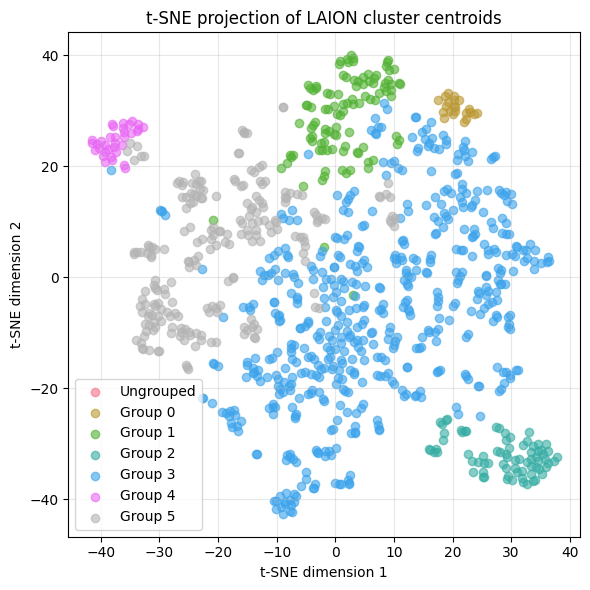


Cluster distribution:
Group 0: 22 clusters
Group 1: 105 clusters
Group 2: 75 clusters
Group 3: 549 clusters
Group 4: 34 clusters
Group 5: 215 clusters
Ungrouped: 0 clusters


In [23]:
# Create figure
plt.figure(figsize=(6, 6))

# Create color palette for groups and ungrouped clusters
n_groups = len(groups)
palette = sns.color_palette("husl", n_groups)
palette = palette + [(0.7, 0.7, 0.7)]  # Add gray for ungrouped clusters

# Plot points
for i in range(-1, n_groups):
    mask = group_labels == i
    label = f"Group {i}" if i >= 0 else "Ungrouped"
    plt.scatter(
        cluster_centers_2d[mask, 0],
        cluster_centers_2d[mask, 1],
        c=[palette[i + 1]],
        label=label,
        alpha=0.6,
    )

plt.title("t-SNE projection of LAION cluster centroids")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(plot_out_dir / "laion_group_clustering_tsne.pdf")
plt.show()

# Print some statistics
print("\nCluster distribution:")
for i in range(n_groups):
    print(f"Group {i}: {len(groups[i])} clusters")
print(f"Ungrouped: {sum(group_labels == -1)} clusters")

In [13]:
cluster_centers = final_kmeans.cluster_centers_
total_n_training = 6000
n_repeats = 1
max_n_ood_samples = 1000
n_cluster_list = [50, 100, 250, 500, 750, 900, 999]

Now for each group of similar clusters, use only the other groups to train a ridge regression model and evaluate the accuracy and mean correlation of the predictions (similar to whats the case for NSD / THINGS).

In [61]:
# cluster_centers = final_kmeans.cluster_centers_
# total_n_training = 6000
# n_repeats = 100

# ood_results = {}
# for cluster_group_idx, cluster_group in tqdm(
#     enumerate(groups), desc="Cluster groups", total=len(groups)
# ):
#     ood_cluster_indices = []
#     ood_cluster_labels = []
#     for ood_cluster in cluster_group:
#         ood_cluster_sample_indices = np.where(laion_subset_labels == ood_cluster)[0]
#         ood_cluster_indices.extend(ood_cluster_sample_indices)
#         ood_cluster_labels.extend(
#             ood_cluster * np.ones(len(ood_cluster_sample_indices))
#         )
#     ood_cluster_labels = np.array(ood_cluster_labels)
#     ood_cluster_indices = np.array(ood_cluster_indices)

#     other_clusters = np.setdiff1d(range(1000), cluster_group)
#     ood_results[cluster_group_idx] = {}

#     random_test_indices = np.random.choice(
#         range(len(ood_cluster_indices)), 1000, replace=False
#     )
#     random_test_labels = np.array([ood_cluster_labels[i] for i in random_test_indices])
#     random_test_samples = ood_cluster_indices[random_test_indices]

#     max_n_clusters = 1000 - len(cluster_group)
#     n_cluster_list = [50, 100, 250, 500, 750, 900]
#     n_cluster_list = [n for n in n_cluster_list if n < max_n_clusters] + [
#         max_n_clusters
#     ]
#     for n_clusters in tqdm(n_cluster_list, desc="Number of clusters", leave=False):
#         ood_results[cluster_group_idx][n_clusters] = {
#             "accuracies": [],
#             "mean_correlations": [],
#             "mean_accuracies": [],
#         }
#         for repeat in tqdm(range(n_repeats), desc="Repeats", leave=False):
#             np.random.seed(repeat)
#             random_clusters = np.random.choice(
#                 other_clusters, n_clusters, replace=False
#             )
#             n_samples_per_cluster = total_n_training // n_clusters

#             training_indices = []
#             for cluster in random_clusters:
#                 training_indices.extend(
#                     np.random.choice(
#                         np.where(laion_subset_labels == cluster)[0],
#                         n_samples_per_cluster,
#                         replace=False,
#                     )
#                 )

#             ridge = RidgeCV()
#             ridge.fit(
#                 laion_subset_fMRI[training_indices], laion_subset[training_indices]
#             )

#             laion_pred = ridge.predict(laion_subset_fMRI[random_test_samples])

#             ood_fMRI_correlations = [
#                 correlation(laion_subset[random_test_samples][idx], laion_pred[idx])
#                 for idx in range(len(random_test_samples))
#             ]

#             laion_pred = final_scaler.transform(laion_pred)

#             ood_accuracies = []
#             for ood_cluster in np.unique(random_test_labels):
#                 cluster_indices = np.where(random_test_labels == ood_cluster)[0]
#                 ood_accuracies.append(
#                     get_cluster_accuracy(
#                         final_kmeans.cluster_centers_,
#                         int(ood_cluster),
#                         laion_pred[cluster_indices],
#                     )
#                 )

#             ood_results[cluster_group_idx][n_clusters]["accuracies"].append(
#                 ood_accuracies
#             )
#             ood_results[cluster_group_idx][n_clusters]["mean_accuracies"].append(
#                 np.mean(ood_accuracies)
#             )
#             ood_results[cluster_group_idx][n_clusters]["mean_correlations"].append(
#                 np.mean(ood_fMRI_correlations)
#             )


Cluster groups:   0%|          | 0/6 [00:00<?, ?it/s]

Number of clusters:   0%|          | 0/6 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Number of clusters:   0%|          | 0/7 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Number of clusters:   0%|          | 0/7 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Number of clusters:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Number of clusters:   0%|          | 0/7 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Number of clusters:   0%|          | 0/6 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
group_ood_results_fp = Path(
    "/home/jroth/controversial_stimuli/experiments/laion/edopt_testing/outputs/3_simulation_vs_existing_datasets/laion_group_ood_results.pkl"
)
# with open(group_ood_results_fp, "wb") as f:
#     pickle.dump(ood_results, f)

In [27]:
ood_results = load_pickle_file(group_ood_results_fp)

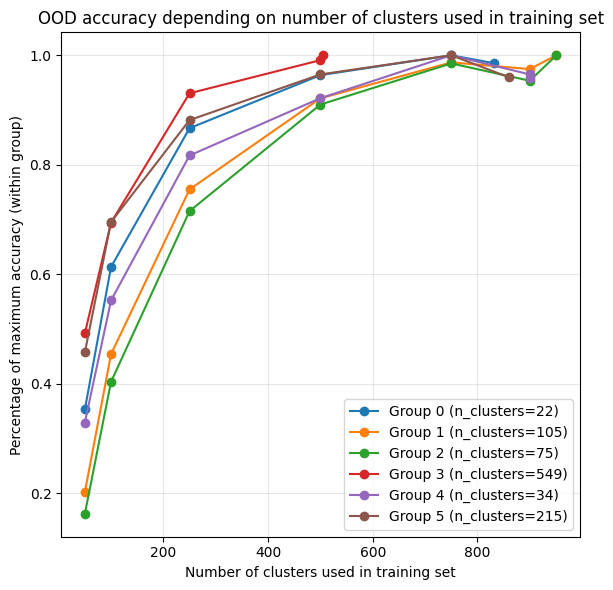

In [ ]:
# Create single plot
plt.figure(figsize=(6, 6))

# Process and normalize data for each group
all_group_data = []
for group_idx in range(n_groups):
    cluster_nrs = [int(n_clusters) for n_clusters in ood_results[group_idx].keys()]
    accuracies = [
        np.mean(ood_results[group_idx][n_clusters]["mean_accuracies"])
        for n_clusters in ood_results[group_idx].keys()
    ]

    # Normalize accuracies within group
    max_acc = max(accuracies)
    norm_accuracies = [acc / max_acc for acc in accuracies]

    all_group_data.append(
        {"cluster_nrs": cluster_nrs, "norm_accuracies": norm_accuracies}
    )

# Plot normalized accuracies for all groups
for group_idx, data in enumerate(all_group_data):
    plt.plot(
        data["cluster_nrs"],
        data["norm_accuracies"],
        marker="o",
        label=f"Group {group_idx} (n_clusters={len(groups[group_idx])})",
    )

plt.grid(True, alpha=0.3)
plt.xlabel("Number of clusters used in training set")
plt.ylabel("Percentage of maximum accuracy (within group)")
plt.title("OOD accuracy depending on number of clusters used in training set")
plt.legend()

plt.tight_layout()
plt.savefig(plot_out_dir / "laion_clustering_ood_results_grouped_normalized.pdf")
plt.show()

In [ ]:
total_n_training = 6000  # Fixed total number of training samples

# Initialize results dictionary
ood_results = {}

# For each group as OOD
for ood_group_idx, ood_cluster_group in tqdm(enumerate(groups), desc="OOD Groups"):
    # Get OOD test samples
    ood_cluster_indices = []
    ood_cluster_labels = []
    for ood_cluster in ood_cluster_group:
        ood_cluster_sample_indices = np.where(laion_subset_labels == ood_cluster)[0]
        ood_cluster_indices.extend(ood_cluster_sample_indices)
        ood_cluster_labels.extend(
            ood_cluster * np.ones(len(ood_cluster_sample_indices))
        )
    ood_cluster_labels = np.array(ood_cluster_labels)
    ood_cluster_indices = np.array(ood_cluster_indices)

    # Sample test indices
    random_test_indices = np.random.choice(
        range(len(ood_cluster_indices)),
        min(1000, len(ood_cluster_indices)),
        replace=False,
    )
    random_test_labels = np.array([ood_cluster_labels[i] for i in random_test_indices])
    random_test_samples = ood_cluster_indices[random_test_indices]

    ood_results[ood_group_idx] = {}

    # Test different combinations of other groups
    for n_other_groups in range(1, len(groups)):
        ood_results[ood_group_idx][n_other_groups] = {
            "accuracies": [],
            "mean_correlations": [],
            "mean_accuracies": [],
            "groups_used": [],
        }

        # Get all possible combinations of other groups
        other_group_indices = [i for i in range(len(groups)) if i != ood_group_idx]
        for group_combination in combinations(other_group_indices, n_other_groups):
            # Get all clusters from selected groups
            training_clusters = []
            for group_idx in group_combination:
                training_clusters.extend(groups[group_idx])

            # Calculate samples per cluster to maintain total_n_training
            n_samples_per_cluster = total_n_training // len(training_clusters)

            # Get balanced samples from these clusters
            training_indices = []
            for cluster in training_clusters:
                cluster_indices = np.where(laion_subset_labels == cluster)[0]
                selected_indices = np.random.choice(
                    cluster_indices,
                    min(n_samples_per_cluster, len(cluster_indices)),
                    replace=False,
                )
                training_indices.extend(selected_indices)

            # Train ridge regression
            ridge = RidgeCV()
            ridge.fit(
                laion_subset_fMRI[training_indices], laion_subset[training_indices]
            )

            # Get predictions
            laion_pred = ridge.predict(laion_subset_fMRI[random_test_samples])

            # Calculate correlations
            ood_fMRI_correlations = [
                correlation(laion_subset[random_test_samples][idx], laion_pred[idx])
                for idx in range(len(random_test_samples))
            ]

            # Transform predictions
            laion_pred = final_scaler.transform(laion_pred)

            # Calculate accuracies for each cluster
            ood_accuracies = []
            for ood_cluster in np.unique(random_test_labels):
                cluster_indices = np.where(random_test_labels == ood_cluster)[0]
                ood_accuracies.append(
                    get_cluster_accuracy(
                        final_kmeans.cluster_centers_,
                        int(ood_cluster),
                        laion_pred[cluster_indices],
                    )
                )

            # Store results
            ood_results[ood_group_idx][n_other_groups]["accuracies"].append(
                ood_accuracies
            )
            ood_results[ood_group_idx][n_other_groups]["mean_accuracies"].append(
                np.mean(ood_accuracies)
            )
            ood_results[ood_group_idx][n_other_groups]["mean_correlations"].append(
                np.mean(ood_fMRI_correlations)
            )
            ood_results[ood_group_idx][n_other_groups]["groups_used"].append(
                group_combination
            )

# Save results

OOD Groups: 0it [00:00, ?it/s]

NameError: name 'pickle' is not defined

In [3]:
import pickle

groupcomb_fp = "/home/jroth/controversial_stimuli/experiments/laion/edopt_testing/outputs/3_simulation_vs_existing_datasets/laion_group_combinations_ood_results.pkl"
# with open(groupcomb_fp, "wb") as f:
#     pickle.dump(ood_results, f)
with open(groupcomb_fp, "rb") as f:
    ood_results = pickle.load(f)

In [4]:
scale = 1.2
plt.rcParams["font.size"] = 12 * scale
plt.rcParams["axes.labelsize"] = 14 * scale
plt.rcParams["axes.titlesize"] = 14 * scale
plt.rcParams["xtick.labelsize"] = 12 * scale
plt.rcParams["ytick.labelsize"] = 12 * scale
plt.rcParams["legend.fontsize"] = 10 * scale

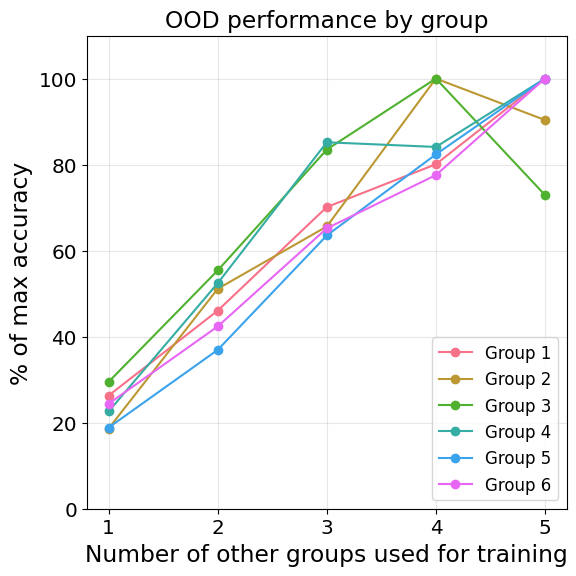


Summary Statistics by Group:

Group 0:
  1 groups: 26.3% ± 23.5%
  2 groups: 46.0% ± 17.1%
  3 groups: 70.1% ± 17.9%
  4 groups: 80.1% ± 17.8%
  5 groups: 100.0% ± 0.0%

Group 1:
  1 groups: 18.6% ± 12.5%
  2 groups: 51.1% ± 16.2%
  3 groups: 65.6% ± 13.2%
  4 groups: 100.0% ± 19.1%
  5 groups: 90.4% ± 0.0%

Group 2:
  1 groups: 29.5% ± 26.4%
  2 groups: 55.4% ± 21.8%
  3 groups: 83.5% ± 23.7%
  4 groups: 100.0% ± 22.5%
  5 groups: 72.9% ± 0.0%

Group 3:
  1 groups: 22.6% ± 13.9%
  2 groups: 52.4% ± 14.6%
  3 groups: 85.2% ± 10.2%
  4 groups: 84.1% ± 5.5%
  5 groups: 100.0% ± 0.0%

Group 4:
  1 groups: 18.9% ± 13.8%
  2 groups: 36.9% ± 12.4%
  3 groups: 63.5% ± 14.2%
  4 groups: 82.4% ± 20.7%
  5 groups: 100.0% ± 0.0%

Group 5:
  1 groups: 24.4% ± 15.9%
  2 groups: 42.4% ± 13.3%
  3 groups: 65.2% ± 15.9%
  4 groups: 77.6% ± 18.0%
  5 groups: 100.0% ± 0.0%


In [5]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plot_out_dir = "/home/jroth/controversial_stimuli/experiments/laion/edopt_testing/notebooks/plots/3_simulate_stimvsfMRI_ed"

# Create single plot
plt.figure(figsize=(6, 6))

# Create color palette for different groups
colors = sns.color_palette("husl", n_colors=len(ood_results))

# Plot each group's performance
for group_idx in ood_results.keys():
    group_data = ood_results[group_idx]

    # Process data for plotting
    x_values = []  # Number of groups used
    y_values = []  # Mean accuracies
    y_errors = []  # Standard errors

    # Find maximum accuracy for this group for normalization
    max_accuracy = max(
        np.mean(results["mean_accuracies"]) for results in group_data.values()
    )

    for n_groups_used, results in group_data.items():
        x_values.append(n_groups_used)
        accuracies = (
            np.array(results["mean_accuracies"]) / max_accuracy * 100
        )  # Convert to percentage
        y_values.append(np.mean(accuracies))
        y_errors.append(np.std(accuracies) / np.sqrt(len(accuracies)))

    # Plot with unique color and label
    plt.errorbar(
        x_values,
        y_values,
        marker="o",
        capsize=5,
        color=colors[int(group_idx)],
        label=f"Group {group_idx + 1}",
    )

plt.xlabel("Number of other groups used for training")
plt.ylabel("% of max accuracy")
plt.title("OOD performance by group")
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 6))  # Use integer x-axis values
plt.ylim(0, 110)  # Set y-limit to slightly above 100%
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(
    os.path.join(plot_out_dir, "laion_group_combinations_all_groups.pdf"),
    bbox_inches="tight",
)
plt.show()

# Print summary statistics for each group
print("\nSummary Statistics by Group:")
for group_idx in sorted(ood_results.keys()):
    print(f"\nGroup {group_idx}:")
    for n_groups_used in sorted(ood_results[group_idx].keys()):
        accuracies = np.array(ood_results[group_idx][n_groups_used]["mean_accuracies"])
        max_accuracy = max(
            np.mean(results["mean_accuracies"])
            for results in ood_results[group_idx].values()
        )
        normalized_accuracies = (accuracies / max_accuracy) * 100
        print(
            f"  {n_groups_used} groups: {np.mean(normalized_accuracies):.1f}% ± {np.std(normalized_accuracies) / np.sqrt(len(normalized_accuracies)):.1f}%"
        )

In [42]:
with open(
    "/home/jroth/controversial_stimuli/experiments/laion/edopt_testing/outputs/3_test_sampling_laion/results_method=random_n_images=6000_random_seed=42.json"
) as f:
    script_results = json.load(f)

In [46]:
np.mean(
    [
        np.mean(script_results["repeats"][i]["ood_accuracy"])
        for i in range(len(script_results["repeats"]))
    ]
)

np.float64(0.0008789523677507103)

## Compare against existing datasets (NSD, THINGS, BOLD5000)

  0%|          | 0/8 [00:00<?, ?it/s]

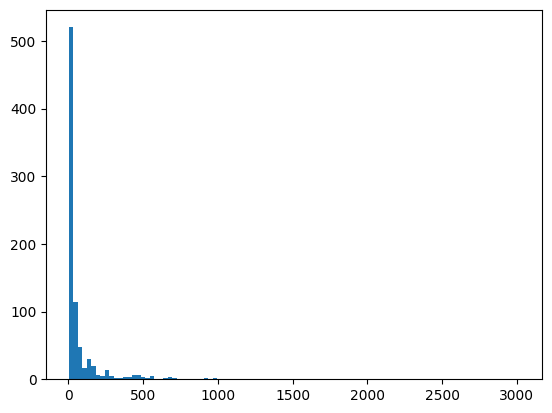

Number of clusters with more than .1% of samples: 176


In [14]:
nsd_features = np.load("/home/jroth/nsd_CLIP_ViT-B32_features.npy")
nsd_labels = assign_to_clusters(nsd_features, final_kmeans, final_scaler)
unique_nsd_labels, nsd_cts = np.unique(nsd_labels, return_counts=True)

plt.hist(nsd_cts, bins=100)
plt.show()
print(
    f"Number of clusters with more than .1% of samples: {sum(nsd_cts > len(nsd_features) / 1000)}"
)

  0%|          | 0/1 [00:00<?, ?it/s]

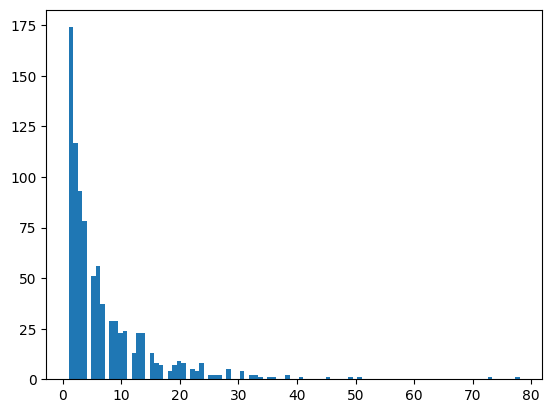

Number of clusters with more than .1% of samples: 304


In [15]:
dv_features = np.load("/home/jroth/dv_p01_embeddings_clip.npz")["arr_0"]
dv_labels = assign_to_clusters(dv_features, final_kmeans, final_scaler)
unique_dv_labels, dv_cts = np.unique(dv_labels, return_counts=True)

plt.hist(dv_cts, bins=100)
plt.show()
print(
    f"Number of clusters with more than .1% of samples: {sum(dv_cts > len(dv_features) / 1000)}"
)

  0%|          | 0/3 [00:00<?, ?it/s]

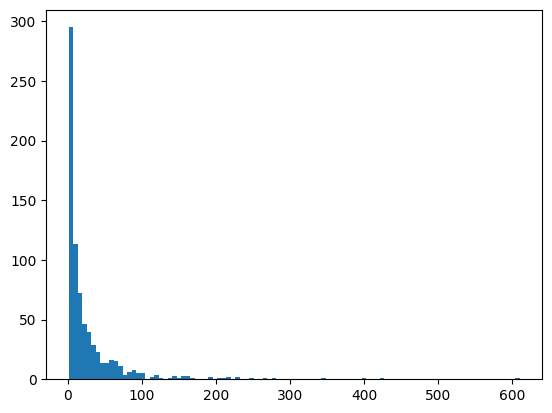

Number of clusters with more than .1% of samples: 259


In [16]:
things_features = np.load("/home/jroth/things_CLIP_embeddings.npz")["arr_0"]
things_labels = assign_to_clusters(things_features, final_kmeans, final_scaler)
unique_things_labels, things_cts = np.unique(things_labels, return_counts=True)

plt.hist(things_cts, bins=100)
plt.show()
print(
    f"Number of clusters with more than .1% of samples: {sum(things_cts > len(things_features) / 1000)}"
)

In [17]:
def eval_group_ood_performance(
    X_train, Y_train, X_test, Y_test, test_cluster_labels, cluster_centers, scaler
):
    ridge = RidgeCV()
    ridge.fit(X_train, Y_train)
    Y_pred = ridge.predict(X_test)
    test_correlations = [
        correlation(Y_test[idx], Y_pred[idx]) for idx in range(len(Y_test))
    ]
    Y_pred = scaler.transform(Y_pred)
    test_accuracies = []
    for cluster in np.unique(test_cluster_labels):
        cluster = int(cluster)
        cluster_indices = np.where(test_cluster_labels == cluster)[0]
        test_accuracies.append(
            get_cluster_accuracy(cluster_centers, cluster, Y_pred[cluster_indices])
        )

    return test_correlations, test_accuracies

In [ ]:
unique_laion_labels, laion_cts = np.unique(laion_labels, return_counts=True)

In [18]:
sigma2_noise = 1
n_repeats = 100

laion_others_comp_results = {group_idx: {} for group_idx in range(len(groups))}
for group_idx in tqdm(range(len(groups)), desc="Group indices"):
    N_test_samples = 1000  # Number of samples to test on

    # Get test samples from the target group
    group_clusters = groups[group_idx]
    group_indices = []
    for cluster in group_clusters:
        group_indices.extend(np.where(laion_subset_labels == cluster)[0])
    group_indices = np.array(group_indices)

    # Get random subset of group samples for testing
    # Sample test indices in a stratified manner across clusters in the group
    test_indices = np.concatenate(
        [
            np.random.choice(
                np.where(laion_subset_labels == cluster)[0],
                N_test_samples
                // len(group_clusters),  # Divide evenly across group clusters
                replace=False,
            )
            for cluster in group_clusters
        ]
    )

    test_cluster_labels = laion_subset_labels[test_indices]
    X_test = laion_subset_fMRI[test_indices]
    Y_test = laion_subset[test_indices]

    N_samples_list = {
        "NSD": len(nsd_features),
        "DV": len(dv_features),
        "THINGS": len(things_features),
    }

    # Evaluate sampling from LAION
    for repeat in tqdm(range(n_repeats)):
        for dataset_name, N_samples in N_samples_list.items():
            if f"LAION-{dataset_name}" not in laion_others_comp_results[group_idx]:
                laion_others_comp_results[group_idx][f"LAION-{dataset_name}"] = []
            # Define sampling strategies
            strategies = {
                "random": lambda: np.random.choice(
                    np.setdiff1d(range(len(laion_subset)), group_indices),
                    N_samples,
                    replace=False,
                ),
                "stratified": lambda: np.concatenate(
                    [
                        np.random.choice(
                            np.where(laion_subset_labels == cluster)[0],
                            N_samples
                            // (
                                1000 - len(group_clusters)
                            ),  # Divide evenly across remaining clusters
                            replace=True,
                        )
                        for cluster in np.setdiff1d(range(1000), group_clusters)
                    ]
                ),
            }

            results = {}
            for strategy_name, sampler in strategies.items():
                # Sample training data
                train_indices = sampler()
                X_train = laion_subset_fMRI[train_indices]
                Y_train = laion_subset[train_indices]

                test_correlations, test_accuracies = eval_group_ood_performance(
                    X_train,
                    Y_train,
                    X_test,
                    Y_test,
                    test_cluster_labels,
                    final_kmeans.cluster_centers_,
                    final_scaler,
                )

                # Store results
                results[strategy_name] = {
                    "mean_correlation": np.mean(test_correlations),
                    "std_correlation": np.std(test_correlations),
                    "mean_accuracy": np.mean(test_accuracies),
                    "std_accuracy": np.std(test_accuracies),
                }

            laion_others_comp_results[group_idx][f"LAION-{dataset_name}"].append(
                results
            )

    # Now evaluate NSD with same methodology
    nsd_train_indices = np.where(~np.isin(nsd_labels, group_clusters))[0]
    nsd_features_train = nsd_features[nsd_train_indices]

    # Generate simulated fMRI data for NSD training samples
    nsd_fMRI = (nsd_features[nsd_train_indices] @ teacher_weights) + np.random.normal(
        loc=0.0, scale=np.sqrt(sigma2_noise), size=(len(nsd_train_indices), D)
    )

    test_correlations, test_accuracies = eval_group_ood_performance(
        nsd_fMRI,
        nsd_features_train,
        X_test,
        Y_test,
        test_cluster_labels,
        final_kmeans.cluster_centers_,
        final_scaler,
    )

    laion_others_comp_results[group_idx]["NSD"] = {
        "mean_correlation": np.mean(test_correlations),
        "std_correlation": np.std(test_correlations),
        "mean_accuracy": np.mean(test_accuracies),
        "std_accuracy": np.std(test_accuracies),
    }

    # Now evaluate DV with same methodology
    dv_train_indices = np.where(~np.isin(dv_labels, group_clusters))[0]
    dv_features_train = dv_features[dv_train_indices]

    dv_fMRI = (dv_features[dv_train_indices] @ teacher_weights) + np.random.normal(
        loc=0.0, scale=np.sqrt(sigma2_noise), size=(len(dv_train_indices), D)
    )

    test_correlations, test_accuracies = eval_group_ood_performance(
        dv_fMRI,
        dv_features_train,
        X_test,
        Y_test,
        test_cluster_labels,
        final_kmeans.cluster_centers_,
        final_scaler,
    )

    laion_others_comp_results[group_idx]["DV"] = {
        "mean_correlation": np.mean(test_correlations),
        "std_correlation": np.std(test_correlations),
        "mean_accuracy": np.mean(test_accuracies),
        "std_accuracy": np.std(test_accuracies),
    }

    # Now evaluate THINGS with same methodology
    things_train_indices = np.where(~np.isin(things_labels, group_clusters))[0]
    things_features_train = things_features[things_train_indices]

    things_fMRI = (
        things_features[things_train_indices] @ teacher_weights
    ) + np.random.normal(
        loc=0.0, scale=np.sqrt(sigma2_noise), size=(len(things_train_indices), D)
    )

    test_correlations, test_accuracies = eval_group_ood_performance(
        things_fMRI,
        things_features_train,
        X_test,
        Y_test,
        test_cluster_labels,
        final_kmeans.cluster_centers_,
        final_scaler,
    )

    laion_others_comp_results[group_idx]["THINGS"] = {
        "mean_correlation": np.mean(test_correlations),
        "std_correlation": np.std(test_correlations),
        "mean_accuracy": np.mean(test_accuracies),
        "std_accuracy": np.std(test_accuracies),
    }

Group indices:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
del laion_features

In [ ]:
nonfilter_laion_features = np.load("/home/jroth/laion_features_nofilter.npy")

In [ ]:
nonfilter_laion_labels = assign_to_clusters(
    nonfilter_laion_features, final_kmeans, final_scaler
)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [ ]:
nonfilter_laion_subset = []
nonfilter_laion_subset_labels = []
for i in range(1000):
    cluster_indices = np.where(nonfilter_laion_labels == i)[0]
    nonfilter_laion_subset.append(
        nonfilter_laion_features[
            np.random.choice(
                cluster_indices, min(500, len(cluster_indices)), replace=False
            )
        ]
    )
    nonfilter_laion_subset_labels.append(i * np.ones(min(500, len(cluster_indices))))
nonfilter_laion_subset = np.concatenate(nonfilter_laion_subset)
nonfilter_laion_subset_labels = np.concatenate(nonfilter_laion_subset_labels)

In [29]:
nonfilter_laion_subset_fMRI = (
    nonfilter_laion_subset @ teacher_weights
) + np.random.normal(
    loc=0.0, scale=np.sqrt(sigma2_noise), size=(len(nonfilter_laion_subset), D)
)

In [69]:
sigma2_noise = 1
n_repeats = 100

nonfilter_laion_others_comp_results = {
    group_idx: [] for group_idx in range(len(groups))
}
for group_idx in tqdm(range(len(groups)), desc="Group indices"):
    N_test_samples = 1000  # Number of samples to test on

    # Get test samples from the target group
    group_clusters = groups[group_idx]
    group_indices = []
    for cluster in group_clusters:
        group_indices.extend(np.where(nonfilter_laion_subset_labels == cluster)[0])
    group_indices = np.array(group_indices)

    # Get random subset of group samples for testing
    # Sample test indices in a stratified manner across clusters in the group
    test_indices = np.concatenate(
        [
            np.random.choice(
                np.where(laion_subset_labels == cluster)[0],
                N_test_samples
                // len(group_clusters),  # Divide evenly across group clusters
                replace=False,
            )
            for cluster in group_clusters
        ]
    )

    test_cluster_labels = laion_subset_labels[test_indices]
    X_test = laion_subset_fMRI[test_indices]
    Y_test = laion_subset[test_indices]

    N_SAMPLES = len(nsd_features)

    # Evaluate sampling from LAION-nonfilter
    for repeat in tqdm(range(n_repeats)):

        def stratified_sampling(labels, group_clusters, N_SAMPLES):
            # Get indices of samples in group_clusters
            indices = []
            for cluster in group_clusters:
                cluster_indices = np.where(labels == cluster)[0]
                indices.append(
                    np.random.choice(
                        cluster_indices,
                        min(
                            N_SAMPLES // (1000 - len(group_clusters)),
                            len(cluster_indices),
                        ),
                        replace=True,
                    )
                )
            return np.concatenate(indices)

        strategies = {
            "random": lambda: np.random.choice(
                np.setdiff1d(range(len(nonfilter_laion_subset)), group_indices),
                N_SAMPLES,
                replace=False,
            ),
        }

        results = {}
        for strategy_name, sampler in strategies.items():
            # Sample training data
            train_indices = sampler()
            X_train = nonfilter_laion_subset_fMRI[train_indices]
            Y_train = nonfilter_laion_subset[train_indices]

            test_correlations, test_accuracies = eval_group_ood_performance(
                X_train,
                Y_train,
                X_test,
                Y_test,
                test_cluster_labels,
                final_kmeans.cluster_centers_,
                final_scaler,
            )

            # Store results
            results[strategy_name] = {
                "mean_correlation": np.mean(test_correlations),
                "std_correlation": np.std(test_correlations),
                "mean_accuracy": np.mean(test_accuracies),
                "std_accuracy": np.std(test_accuracies),
            }

        nonfilter_laion_others_comp_results[group_idx].append(results)

Group indices:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [70]:
# import json

nonfilter_laion_comp_result_fp = "/home/jroth/controversial_stimuli/experiments/laion/edopt_testing/outputs/3_simulation_vs_existing_datasets/nonfilter_laion_others_comp_results.json"
if not os.path.exists(nonfilter_laion_comp_result_fp):
    with open(nonfilter_laion_comp_result_fp, "w") as f:
        json.dump(nonfilter_laion_others_comp_results, f)
# else:
#     with open(nonfilter_laion_comp_result_fp, "r") as f:
#         nonfilter_laion_others_comp_results = json.load(f)

In [38]:
# # import pickle
# import os
laion_others_comp_result_fp = "/home/jroth/controversial_stimuli/experiments/laion/edopt_testing/outputs/3_simulation_vs_existing_datasets/laion_others_comp_results.json"
# if not os.path.exists(laion_others_comp_result_fp):
#     with open(laion_others_comp_result_fp, "w") as f:
#         json.dump(laion_others_comp_results, f)

In [39]:
import json

with open(laion_others_comp_result_fp, "r") as f:
    laion_others_comp_results = json.load(f)

In [ ]:
laion_others_comp_results["0"]

{'LAION-NSD': [{'random': {'mean_correlation': 0.7913565697909342,
    'std_correlation': 0.03489126179683615,
    'mean_accuracy': 0.202020202020202,
    'std_accuracy': 0.13778903357559544},
   'stratified': {'mean_correlation': 0.7922856233380211,
    'std_correlation': 0.03450166483130553,
    'mean_accuracy': 0.19696969696969696,
    'std_accuracy': 0.13270820704662098}},
  {'random': {'mean_correlation': 0.7918875236534657,
    'std_correlation': 0.03477208625127177,
    'mean_accuracy': 0.18989898989898987,
    'std_accuracy': 0.13328741174308434},
   'stratified': {'mean_correlation': 0.7914649411792949,
    'std_correlation': 0.035115710900669,
    'mean_accuracy': 0.20404040404040408,
    'std_accuracy': 0.13758154217358726}},
  {'random': {'mean_correlation': 0.7921832579475027,
    'std_correlation': 0.03467724952120797,
    'mean_accuracy': 0.204040404040404,
    'std_accuracy': 0.13444592429878657},
   'stratified': {'mean_correlation': 0.7921463146528884,
    'std_correl

In [71]:
for group_idx in laion_others_comp_results:
    laion_others_comp_results[group_idx]["LAION-nonfilter"] = (
        nonfilter_laion_others_comp_results[int(group_idx)]
    )

In [72]:
group_sizes = [len(group) for group in groups]

In [39]:
normalized_df = pd.DataFrame()

# First normalize within each group and dataset size
for group in df["Group"].unique():
    group_data = df[df["Group"] == group]

    # Split by dataset size
    nsd_data = group_data[
        group_data["Dataset_Strategy"].str.contains("NSD|LAION (NSD-sized)")
    ]
    things_data = group_data[
        group_data["Dataset_Strategy"].str.contains("THINGS|LAION (THINGS-sized)")
    ]
    dv_data = group_data[
        group_data["Dataset_Strategy"].str.contains("DV|LAION (DV-sized)")
    ]

    # Normalize each subset
    for subset in [nsd_data, things_data, dv_data]:
        if not subset.empty:
            max_accuracy = subset["Accuracy"].max()
            subset_normalized = subset.copy()
            subset_normalized["Normalized_Accuracy"] = subset["Accuracy"] / max_accuracy
            normalized_df = pd.concat([normalized_df, subset_normalized])

/tmp/ipykernel_3587523/270454073.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  nsd_data = group_data[group_data["Dataset_Strategy"].str.contains("NSD|LAION (NSD-sized)")]
/tmp/ipykernel_3587523/270454073.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  things_data = group_data[group_data["Dataset_Strategy"].str.contains("THINGS|LAION (THINGS-sized)")]
/tmp/ipykernel_3587523/270454073.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dv_data = group_data[group_data["Dataset_Strategy"].str.contains("DV|LAION (DV-sized)")]
/tmp/ipykernel_3587523/270454073.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  nsd_data = group_data

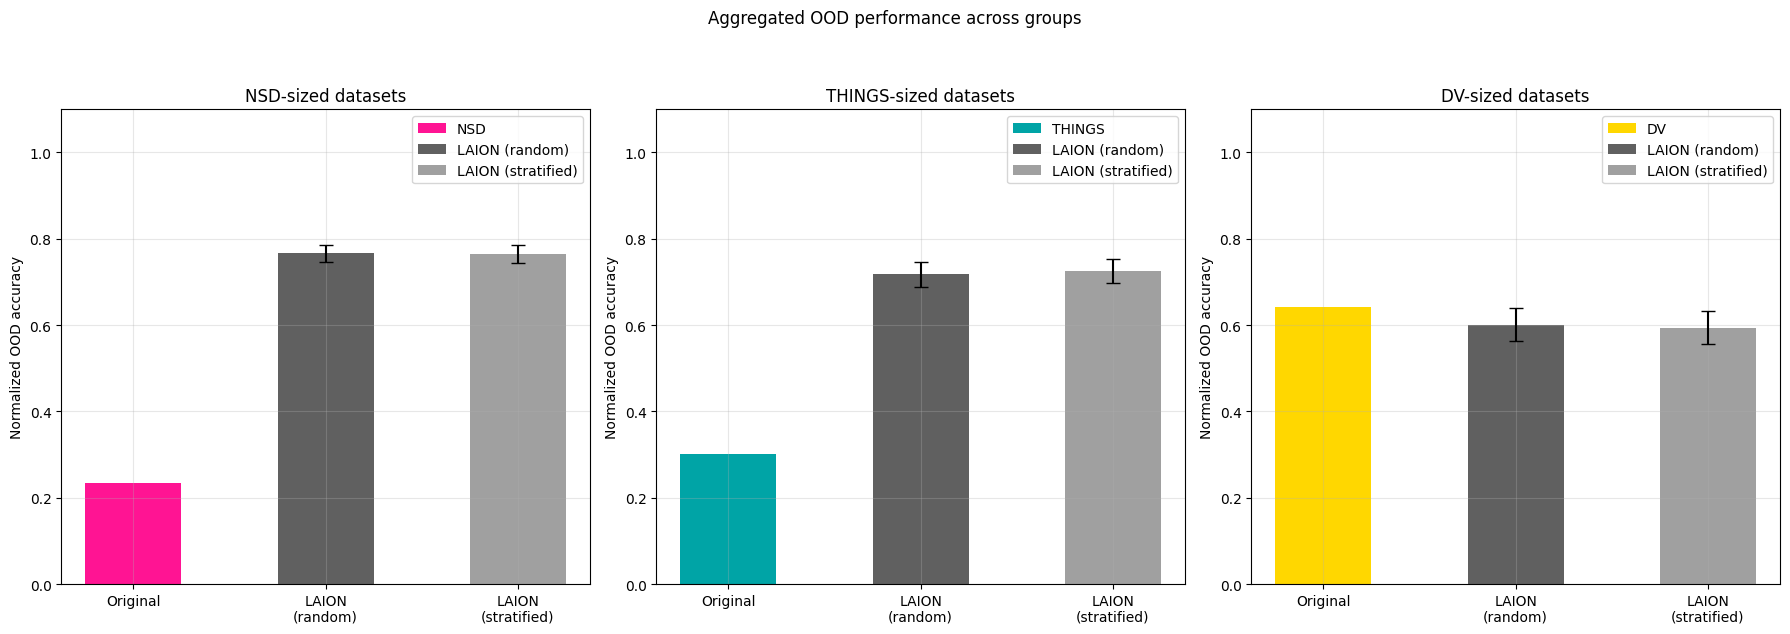


Statistical Summary:

NSD-sized datasets:
                                mean    std  count
Dataset_Strategy                                  
LAION (NSD-sized, random)      0.767  0.125    600
LAION (NSD-sized, stratified)  0.765  0.126    600
NSD                            0.235  0.238      6

THINGS-sized datasets:
                                   mean    std  count
Dataset_Strategy                                     
LAION (THINGS-sized, random)      0.718  0.137    600
LAION (THINGS-sized, stratified)  0.725  0.140    600
THINGS                            0.300  0.182      6


In [74]:
# Create figure with two subplots (one for NSD-sized, one for THINGS-sized)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# First normalize within each group
normalized_results = {}
for group in df["Group"].unique():
    group_data = df[df["Group"] == group]

    # Find max accuracy for this group
    max_accuracy = group_data["Accuracy"].max()

    # Store normalized values
    normalized_results[group] = group_data.copy()
    normalized_results[group]["Normalized_Accuracy"] = (
        group_data["Accuracy"] / max_accuracy
    )

# Combine all normalized results
normalized_df = pd.concat(normalized_results.values())

# Split data by dataset size
nsd_data = normalized_df[
    normalized_df["Dataset_Strategy"].str.contains("NSD|LAION-NSD")
]
things_data = normalized_df[
    normalized_df["Dataset_Strategy"].str.contains("THINGS|LAION-THINGS")
]
dv_data = normalized_df[normalized_df["Dataset_Strategy"].str.contains("DV|LAION-DV")]


# Function to plot dataset comparison
def plot_dataset_comparison(data, ax, title):
    # Separate original and LAION strategies
    original = data[~data["Dataset_Strategy"].str.contains("LAION")]
    laion_random = data[data["Dataset_Strategy"].str.contains("random")]
    laion_stratified = data[data["Dataset_Strategy"].str.contains("stratified")]

    # Calculate means and standard errors
    def get_stats(df, strategy):
        stats = (
            df[df["Dataset_Strategy"].str.contains(strategy)]
            .groupby("Group")["Normalized_Accuracy"]
            .agg(["mean", "std"])
            .reset_index()
        )
        stats["se"] = stats["std"] / np.sqrt(len(df["Group"].unique()))
        return stats

    original_stats = get_stats(original, original["Dataset_Strategy"].iloc[0])
    laion_random_stats = get_stats(laion_random, "random")
    laion_stratified_stats = get_stats(laion_stratified, "stratified")

    # Plot bars
    x = np.arange(3)
    width = 0.5

    if "NSD" in title:
        dataset_color = dataset_colors["NSD"]
    elif "THINGS" in title:
        dataset_color = dataset_colors["THINGS"]
    else:
        dataset_color = dataset_colors["DV"]

    ax.bar(
        x[0],
        original_stats["mean"].mean(),
        width,
        yerr=original_stats["se"].mean(),
        color=dataset_color,
        label=title.split("-")[0].strip(),
        capsize=5,
    )

    ax.bar(
        x[1],
        laion_random_stats["mean"].mean(),
        width,
        yerr=laion_random_stats["se"].mean(),
        color=laion_colors[0],
        label="LAION (random)",
        capsize=5,
    )

    ax.bar(
        x[2],
        laion_stratified_stats["mean"].mean(),
        width,
        yerr=laion_stratified_stats["se"].mean(),
        color=laion_colors[1],
        label="LAION (stratified)",
        capsize=5,
    )

    # Customize plot
    ax.set_ylabel("Normalized OOD accuracy")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(["Original", "LAION\n(random)", "LAION\n(stratified)"])
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3)
    ax.legend()


# Create plots
plot_dataset_comparison(nsd_data, ax1, "NSD-sized datasets")
plot_dataset_comparison(things_data, ax2, "THINGS-sized datasets")
plot_dataset_comparison(dv_data, ax3, "DV-sized datasets")

plt.suptitle("Aggregated OOD performance across groups", y=1.05)
plt.tight_layout()
# plt.savefig(plot_out_dir / "accuracy_vs_nsdthingslaionrandom.pdf")
plt.show()

# Print statistical summary
print("\nStatistical Summary:")
for size in ["NSD", "THINGS"]:
    print(f"\n{size}-sized datasets:")
    data = nsd_data if size == "NSD" else things_data
    summary = data.groupby("Dataset_Strategy")["Normalized_Accuracy"].agg(
        ["mean", "std", "count"]
    )
    print(summary.round(3))